In [4]:
%cd ..

c:\Users\ernes\Documents\ML Projects\ds-project-test\ds-project-test


In [12]:
from src.ds_project.utils.utils import load_binary_data
from pathlib import Path

model_path=Path('artifact/model_validator/best_model/model.pkl')
model=load_binary_data(model_path)

2025-05-13 20:02:21 - INFO: utils - Binary file artifact\model_validator\best_model\model.pkl loaded successfully.


In [13]:
import pandas as pd

data_dir = Path('artifact/data_ingestion/train_data/train.csv')

data=pd.read_csv(data_dir)
data.head()

,num__Pclass,num__Age,num__SibSp,num__Parch,num__Fare,cat__Sex_female,cat__Sex_male,cat__Embarked_C,cat__Embarked_Q,cat__Embarked_S,Survived
0,-1.586525,0.489985,-0.492191,1.938885,0.737107,1.0,0.0,0.0,0.0,1.0,1
1,0.824587,0.097183,-0.492191,-0.476664,-0.473978,0.0,1.0,0.0,0.0,1.0,1
2,-0.380969,-1.238343,0.420413,-0.476664,-0.048763,1.0,0.0,1.0,0.0,0.0,1
3,0.824587,-0.766981,-0.492191,-0.476664,-0.490779,0.0,1.0,0.0,0.0,1.0,0
4,-1.586525,2.532555,-0.492191,-0.476664,0.909914,1.0,0.0,0.0,0.0,1.0,1


In [14]:
import shap

x_train = data.drop(['Survived'], axis=1)
x_train_sample = x_train.sample(100)

explainer = shap.Explainer(model.predict, x_train_sample)
explained = explainer(x_train)

In [27]:
data.columns

Index(['num__Pclass', 'num__Age', 'num__SibSp', 'num__Parch', 'num__Fare',
       'cat__Sex_female', 'cat__Sex_male', 'cat__Embarked_C',
       'cat__Embarked_Q', 'cat__Embarked_S', 'Survived'],
      dtype='object')

.values =
array([[ 2.13190476e-01, -1.19476190e-01, -5.04761905e-02,
         1.11666667e-02,  9.02380952e-03, -1.70142857e-01,
        -1.68642857e-01,  1.73472348e-18,  1.73472348e-18,
        -5.46428571e-02]])

.base_values =
array([0.33])

.data =
array([[-1.58652527,  0.56854551,  0.42041333, -0.47666366,  0.39341414,
         0.        ,  1.        ,  0.        ,  0.        ,  1.        ]])


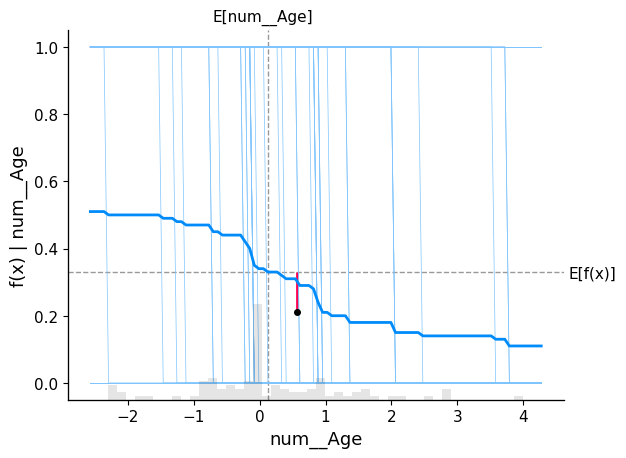

In [36]:
idx=41

print(explained[idx:idx+1, :])
shap.partial_dependence_plot(
    'num__Age',
    model.predict,
    x_train_sample,
    model_expected_value=True,
    feature_expected_value=True,
    shap_values=explained[idx: idx+1, :]
)

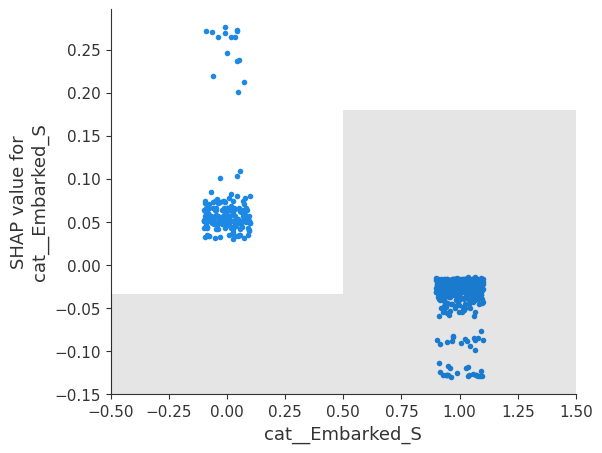

In [43]:
shap.plots.scatter(explained[:, 'cat__Embarked_S'])

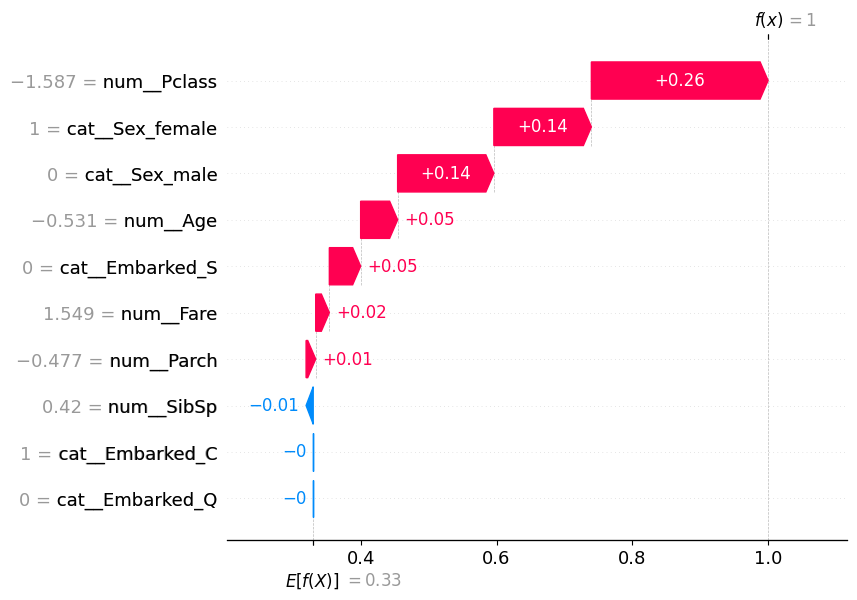

In [40]:
shap.plots.waterfall(explained[idx+10])

In [19]:
for i in range(x_train.shape[1]):
    print(f"{x_train.columns[i]} : {model.coef_[0][i]}")

num__Pclass : -0.9381635005505206
num__Age : -0.3930522438955409
num__SibSp : -0.33780230415390744
num__Parch : -0.09723649685000829
num__Fare : 0.10126310116345864
cat__Sex_female : 1.3682330880968392
cat__Sex_male : -1.3189861679935282
cat__Embarked_C : 0.0
cat__Embarked_Q : 0.0
cat__Embarked_S : -0.46305028708135965


In [20]:
import matplotlib.pyplot as plt

cmap=plt.cm.RdYlBu
norm=plt.Normalize(vmin=min(model.coef_[0]), vmax=max(model.coef_[0]))

In [21]:
norm(model.coef_[0])

masked_array(data=[0.14171626, 0.34456955, 0.36512981, 0.45465202,
                   0.52852006, 1.        , 0.        , 0.49083683,
                   0.49083683, 0.31852104],
             mask=False,
       fill_value=1e+20)

In [22]:
coefs = pd.DataFrame(model.coef_, columns=model.feature_names_in_, index=['coeffs']).T.sort_values('coeffs', ascending=False)

In [23]:
coefs.index

Index(['cat__Sex_female', 'num__Fare', 'cat__Embarked_Q', 'cat__Embarked_C',
       'num__Parch', 'num__SibSp', 'num__Age', 'cat__Embarked_S',
       'num__Pclass', 'cat__Sex_male'],
      dtype='object')

In [24]:
def reformat_columns(columns):
    reformated = [col.replace('cat__', '') for col in columns]
    reformated = [col.replace('num__','') for col in reformated]

    return reformated

In [25]:
reformatted_cols = reformat_columns(coefs.index)

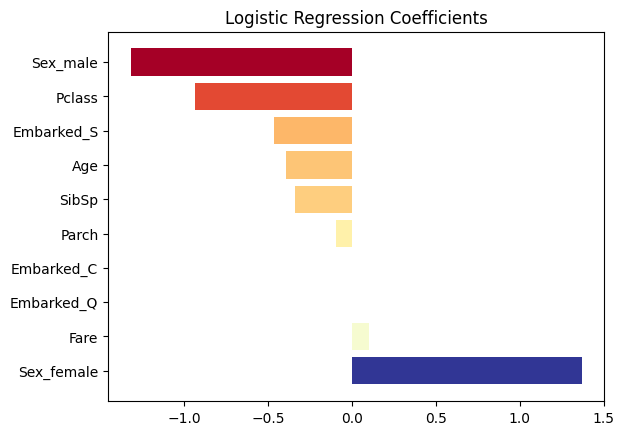

In [26]:
plt.barh(reformatted_cols, coefs.values.reshape(-1), color=cmap(norm(coefs.values.reshape(-1))))
plt.title('Logistic Regression Coefficients')
plt.show()

In [25]:
model.feature_names_in_

array(['num__Pclass', 'num__Age', 'num__SibSp', 'num__Parch', 'num__Fare',
       'cat__Sex_female', 'cat__Sex_male', 'cat__Embarked_C',
       'cat__Embarked_Q', 'cat__Embarked_S'], dtype=object)

In [44]:
from dataclasses import dataclass
from pathlib import Path

@dataclass
class ExplainerConfig:
    explainer_path: Path
    model_type: str

In [ ]:
from src.ds_project.constants import CONFIG_FILE_PATH
from src.ds_project.utils.utils import read_yaml
import shap


class ExplainerManager:
    def __init__(self,
                 model_type:str,
                 config_path = CONFIG_FILE_PATH, ):
        self.config=read_yaml(config_path)
        self.model_type=model_type

    def get_explainer_config():

        config = ExplainerConfig(
            self.config.
        )
